# LightTag API 

Welcome to the LightTag API tutorial. This tutorial consists of 3 parts
1. Part 1 covers quickly defining schemas, datasets and tasks
2. Part 2 covers retreiving metrics about your projects
3. Part 3 covers updating configuratons and appending data

## Introduction
LightTag allows you to annotate a **Dataset** with a **Schema**. A combination of the two, together with some paramaters is called a **Task Definition** (TD for short). Your Datasets,Schemas and Task Definitions live inside of a **Project**.  

The **Examples** you will be annotating live inside of the Dataset. During annotation, you will apply a **Tag** to parts of an Example, classify the overall Example with **ClassificationTypes** or both. Tags and Classification Types live inside of a Schema. 
With exception of a Task Definition, each of these objects has a name, through which you can access it. (Task Definitions only have ids). 

Thus, the URL structure follows a nested hierarchy 
* **/api/v1/projects/** All of the projects

* **/api/v1/projects/some-project/** Details about the project named "some-project"

* **/api/v1/projects/some-project/datasets/** All of the Datasets that belong to "some-project"
* **/api/v1/projects/some-project/datasets/dataset-1/** Details about the dataset "dataset-1" which belongs to "some-project"
* **/api/v1/projects/some-project/schemas/** All of the Schemas that belong to "some-project"
* **/api/v1/projects/some-project/schemas/schema-1/** Details about the dataset "dataset-1" which belongs to "some-project"

etc.. (The detailed endpoints are enumerated in part 3



### A note on naming
You are free to name your datasets,projects schemas and tags as you wish. To ensure a consistent URL, LightTag will calculate a [Slug](https://en.wikipedia.org/wiki/Clean_URL#Slug). 

For example, if we were to create a dataset called *I am a Dataset;;-100* it's slug would be *i-am-a-dataset-100* and it's url would be **/api/v1/projects/some-project/datasets/i-am-a-dataset-100/ **

You can always find the Slug and the URL for a resource by querying it's parent, for example querying all datasets of a project will show you the slug and url for each dataset,as we'll see shortly



## A note on Projects
At the time of writing, the LightTag API supports multiple projects but the built in UI supports a single project, the **default project**, whose url is /api/v1/projects/default/.  

As you use the API, DO NOT define a new project if you intend to consume the data via the UI, instead use the default project. 

# Part 0 - Authentication
LightTag's authentication is via a token which you acquire with your username and password. 
Most endpoints can only be accessed by a manager role, so make sure you are using your manager role when following this example

In [7]:
import requests
import pandas as pd

LIGHTTAG_DOMAIN = 'demo'  #should be your lighttag domain
SERVER = 'https://{domain}.lighttag.io/api/'.format(domain=LIGHTTAG_DOMAIN) 
API_BASE = SERVER +'v1/'
MY_USER='YOUR_USER_HERE'
MY_PWD='MY_PWSED_HERE'

In [23]:
response = requests.post(SERVER+'auth/token/login/',
              json={"username":MY_USER,"password":MY_PWD})
assert response.status_code ==200, "Couldn't authenticate"
auth_details = response.json()
token = auth_details['key']
assert auth_details['is_manager'] ==1, "not a manager" # Check you are a manager


In [24]:
#It's convenient to set up a requests session instead of repeating tokens
session = requests.session()
session.headers.update({"Authorization":"Token {token}".format(token=token)})
#Try it out
session.get(API_BASE+'projects/').json()

[{'id': '2753ca38-69d9-4c96-9d31-df6d4069b027',
  'slug': 'default',
  'url': 'https://demo.lighttag.io/api/v1/projects/default/',
  'name': 'default'}]

Great! We are authenticted and can see the default project

# Part 1 - Quickly setting up a project
Adhering to the UI onboarding process, LightTag's API allows you to define a Dataset, Schema and Tasks in bulk, instead of uploading individual tags or examples one by one. This section will go over how we do that. We'll follow the following hypothetical use case:

We'd like to have a *team* of annotators label President Trump's tweets. We want to label both entities in the tweet (Person,Location...) as well as the sentiment of the tweet, e.g. a classification.

We'd like to have a very high quality test set and a larger training set, for which we'll tolerate some noise. 

Before we go ahead and label the whole thing, we'd to do some experiments: First to see if our Schema makes sense to our labelers, and second to see if it is more convenient to label entities and sentiment together, or do it as individual tasks. 

To achieve this we'll follow the following steps:

1. Split our dataset into a traing and test set

2. Set aside part of the training set for experimentation

3. Define and upload our Datasets

4. Define and upload our Schema

5. Defining Teams

5. Define the tasks (small evaluation, training set labeling, test set labeling)

In ourder to keep this section focused on quickly uploading, we will hold over evalutation till section 3. In a usual use case you will probably first upload a small evaluation set, review the results, iterate and then set out on labeling the full training/test sets



## 1.1 Preparing our dataset
We've conveniently prepared a collection of President Trump's tweets in a JSON file. These will be our examples. We'll load them and divide them into a training set, test set and further take a slice of the training set for exploration 

In [25]:
import json
from pprint import pprint

all_data = json.load(open('./trump3.json'))
pprint(all_data[0])
pprint("total of {num} examples".format(num=len(all_data)))


{'created_at': 'Mon Jan 01 13:37:52 +0000 2018',
 'date': '2018-01-01',
 'favorite_count': 54056,
 'id_str': '947824196909961216',
 'in_reply_to_user_id_str': None,
 'is_retweet': False,
 'retweet_count': 8656,
 'source': 'Twitter for iPhone',
 'text': 'Will be leaving Florida for Washington (D.C.) today at 4:00 P.M. '
         'Much work to be done, but it will be a great New Year!',
 'time': 1514813872000000000}
'total of 2605 examples'


In [26]:
train,test = all_data[:2000], all_data[2000:] # 2000 train examples, 600 test examples
exploratory = train[:50] # Take 50 examples from the training set for exploratory work

## Uploading our exploratory dataset
To upload our dataset, we send over the whole JSON object. We need to tell LightTag which field contains the text to be annotated. Additionaly, we need to specify
1. A name for the dataset
2. An optional aggregation field (If specified, all examples with the value will be shown together)
3. An optional sort field (If secified with an aggregation field, examples will be displayed ordered by that field)

In [30]:
exploratory_dataset = {
    "name":"Exploratory Dataset1",
    "content_field":"text", # text is the field in the JSON we will be annotating
    "examples" :exploratory # Set the list of examples that are part of this dataset
}

In [31]:
#POST the dataset definition and the examples 
resp= session.post(API_BASE+'projects/default/datasets/bulk/',json=exploratory_dataset)
assert resp.status_code ==201

In [32]:
datasets = session.get(API_BASE+'projects/default/datasets/').json() # Get all of the datasets in our project
datasets

[{'id': '2a6e0c06-017d-473c-b3d5-bbb24c28b71c',
  'slug': 'bible',
  'url': 'https://demo.lighttag.io/api/v1/projects/default/datasets/bible/',
  'name': 'Bible',
  'id_field': None,
  'content_field': 'content',
  'aggregation_field': 'chapter',
  'order_field': 'verse',
  'project_id': '2753ca38-69d9-4c96-9d31-df6d4069b027',
  'upload_status': 'done',
  'archived': False},
 {'id': '1bf62f49-d88e-4bf0-9178-79012ce355c4',
  'slug': 'drilling-comments-small',
  'url': 'https://demo.lighttag.io/api/v1/projects/default/datasets/drilling-comments-small/',
  'name': 'Drilling Comments Small',
  'id_field': 'FIELD1',
  'content_field': 'FIELD2',
  'aggregation_field': None,
  'order_field': None,
  'project_id': '2753ca38-69d9-4c96-9d31-df6d4069b027',
  'upload_status': 'done',
  'archived': False},
 {'id': '1709c71b-2092-4d6b-800c-1341cae915ec',
  'slug': 'some-new-dataset',
  'url': 'https://demo.lighttag.io/api/v1/projects/default/datasets/some-new-dataset/',
  'name': 'Some new dataset',

In [154]:
#See the examples in our dataset
session.get(datasets[0]['url']+'examples/').json()[:2]

[{'aggregation_value': None,
  'content': 'RT @shawgerald4: @realDonaldTrump Thank you President TRUMP!! https://t.co/LKdkT0FL99',
  'dataset': 'ee688ba1-b0d3-4fdb-9355-d7924e3875e4',
  'id': '4f028792-9c84-42be-99e5-09db63524687',
  'metadata': {'created_at': 'Sun Dec 24 12:31:48 +0000 2017',
   'date': '2017-12-24',
   'favorite_count': 0,
   'id_str': '944908467499884544',
   'in_reply_to_user_id_str': None,
   'is_retweet': True,
   'retweet_count': 11846,
   'source': 'Twitter for iPhone',
   'time': 1514118708000000000}},
 {'aggregation_value': None,
  'content': 'The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!',
  'dataset': 'ee688ba1-b0d3-4fdb-9355-d7924e3875e4',
  'id': '20e8dd31-5e45-44b5-94aa-bb0d6699609f',
  'metadata': {'created_at': 'Sun Dec 24 13:48:11 +0000 2017',
   'date': '2017-12-24',

### Uploading with an Aggregation field
As mentioned, we can tell LightTag to show examples together, and in what order by specifying an aggregation key and order key. Let's do that for the test and train set

In [155]:
train_dataset = {
    "name":"Training Set",
    "content_field":"text", # text is the field in the JSON we will be annotating
    "examples" :train, # Set the list of examples that are part of this dataset
    "aggregation_field":"date", # Show all tweets from the same day together
    "order_field":"time" # And sort them by time
}

test_dataset = {
    "name":"Test Set",
    "content_field":"text", # text is the field in the JSON we will be annotating
    "examples" :test, # Set the list of examples that are part of this dataset
    "aggregation_field":"date", # Show all tweets from the same day together
    "order_field":"time" # And sort them by time
}

In [156]:
# Upload the training set
resp = session.post(API_BASE+'projects/default/datasets/bulk/',json=train_dataset)
assert resp.status_code ==201
# Upload the test set
resp = session.post(API_BASE+'projects/default/datasets/bulk/',json=test_dataset)
assert resp.status_code ==201


In [157]:
# Let's see all of the Datasets in our project
datasets = session.get(API_BASE+'projects/default/datasets/').json() # Get all of the datasets in our project
pprint(datasets)

[{'aggregation_field': 'date',
  'content_field': 'text',
  'id': '92ea39c8-1d7d-47eb-b6d3-25ceebc6ba33',
  'id_field': None,
  'name': 'Test Set',
  'order_field': 'time',
  'project_id': 'e488e45a-564a-4b93-8beb-f7aa4c73ea97',
  'slug': 'test-set',
  'url': 'http://localhost:8000/api/v1/projects/default/datasets/test-set/'},
 {'aggregation_field': 'date',
  'content_field': 'text',
  'id': 'de7ed65d-e685-4ea9-bf3b-0c3c10f20b46',
  'id_field': None,
  'name': 'Training Set',
  'order_field': 'time',
  'project_id': 'e488e45a-564a-4b93-8beb-f7aa4c73ea97',
  'slug': 'training-set',
  'url': 'http://localhost:8000/api/v1/projects/default/datasets/training-set/'},
 {'aggregation_field': None,
  'content_field': 'text',
  'id': 'ee688ba1-b0d3-4fdb-9355-d7924e3875e4',
  'id_field': None,
  'name': 'Exploratory Dataset',
  'order_field': None,
  'project_id': 'e488e45a-564a-4b93-8beb-f7aa4c73ea97',
  'slug': 'exploratory-dataset',
  'url': 'http://localhost:8000/api/v1/projects/default/datas

## Defining our Schemas
The schema defines how we label our examples. A schema can either define classification types for classifying an example, tags for tagging parts of an example or both. We'll define all three options

### Defining Classification types
We simply define a list of classification types, each item has a name (The class) and a description. The labelers will be able to see the description as they work. 
Remember to give your annotators an UNK or Confusing class. 

In [158]:

classification_types=[
    {
        "name":"Insult", 
        "description":"This tweet contains an insult to a particular person"
    },
    {
        "name":"Praise", 
        "description":"This tweet contains praise of a particular person"
    },
    {
        "name":"Confusing", 
        "description":"This tweet is ambiguous"
    },
    {
        "name":"UNK", 
        "description":"This tweet is niether an insult or praise"
    },
]



### Defining tags
We simply define a list of tags, each item has a name (The tag) and a description. The labelers will be able to see the description as they work. 
 

In [159]:
tags=[
    {
        "name":"Person", 
        "description":"The proper name of a person (John is a person. He is not)"
    },
    {
        "name":"Place",
        "description": "A physical place. For example the White House."
    },
    {
        "name":"Issue",
        "description": "A political issue the President is discussing."
    },
    {
        "name":"Insult",
        "description": "A word or phrase that is unsulting."
    },
    {
        "name":"Media organization",
        "description": "CNN/Fox etc."
    },
    {
        "name":"Politcal Group",
        "description": "Republicans/Democrates etc"
    },
]

### Making a Schema
To define a schema, we give it a name and specify classification types, tags or both. 

In [160]:
classification_only_schema= {
    "name" :"Trump Insult Classification",
    "classification_types":classification_types,
}

tags_only_schema ={
    "name":"Entity Tags only",
    "tags":tags
}

tags_and_classifications_schema = {
    "name": "Classifications and tags Schema",
    "tags":tags,
    "classification_types":classification_types
}


### Uploading the schema
We simply post the schema definition to the projects /schemas/bulk/ endpoint

In [161]:

resp = session.post(API_BASE+'projects/default/schemas/bulk/',json=classification_only_schema)
assert resp.status_code ==201

resp = session.post(API_BASE+'projects/default/schemas/bulk/',json=tags_only_schema)
assert resp.status_code ==201

resp = session.post(API_BASE+'projects/default/schemas/bulk/',json=tags_and_classifications_schema)
assert resp.status_code ==201

In [162]:
# Indeed we now have three schemas
(session.get(API_BASE+'projects/default/schemas/').json())

[{'id': '3b73c2b2-73aa-4c42-a265-a0c459abd295',
  'name': 'Classifications and tags Schema',
  'slug': 'classifications-and-tags-schema',
  'url': 'http://localhost:8000/api/v1/projects/default/schemas/classifications-and-tags-schema/'},
 {'id': 'fbe6fd1d-bb59-4909-8a88-81772cc0d996',
  'name': 'Entity Tags only',
  'slug': 'entity-tags-only',
  'url': 'http://localhost:8000/api/v1/projects/default/schemas/entity-tags-only/'},
 {'id': '9dcf0091-d82c-4292-a09d-eaff062fc1c4',
  'name': 'Trump Insult Classification',
  'slug': 'trump-insult-classification',
  'url': 'http://localhost:8000/api/v1/projects/default/schemas/trump-insult-classification/'}]

**WAIT**
If you are following this tutorial in order to use your own suggestions, you might want to pause, go to the suggestions section and then come back

## Defining Teams
LightTag allows us to assign specific work to one or more teams. Thus, we must specify at least one team that will work on a task. LightTag automatically provides a team that holds "Everyone", e.g. all of your annotators and you can define more teams.


### Getting a list of existing teams
We can query the teams end point of a project to see the availble teams

In [163]:
(session.get(API_BASE+'projects/default/teams/').json())

[{'description': '',
  'id': 'dd40e50b-2ffa-4943-b5ca-6983dba36331',
  'members': [{'id': 1, 'username': 'demo'}],
  'name': 'Everyone',
  'slug': 'everyone',
  'url': 'http://localhost:8000/api/v1/projects/default/teams/everyone/'}]

### Creating a new team
Sometimes we want to have seperate teams. Two common use cases are
1. Limiting access to certain datasets to specific teams
2. Having "experts" label the test set and "experts" + "layman" label the training set

To create a new team, we'll provide a list of annotator ids, a name and a description to the teams endpoint
#### First we get a list of availble annotators

In [166]:
annotators = (session.get(API_BASE+'projects/default/annotators/').json())
annotators

[{'id': 1, 'username': 'demo'},
 {'id': 2, 'username': 'Bob'},
 {'id': 3, 'username': 'Hanz'},
 {'id': 4, 'username': 'Franz'}]

In [167]:
experts = annotators[:3]
layman = annotators[3:]

#### Now we define our teams


In [168]:
expertTeam = {"name":"Experts", "description": "People who are very knowledgable about twitter", "members":experts}
layManTeam = {"name":"Layman",  "description": "People who know a little about twitter", "members":layman}

In [169]:
session.post(API_BASE+'projects/default/teams/',json=expertTeam)
session.post(API_BASE+'projects/default/teams/',json=layManTeam)
teams = session.get(API_BASE+'projects/default/teams/').json()
pprint(teams)

[{'description': '',
  'id': 'dd40e50b-2ffa-4943-b5ca-6983dba36331',
  'members': [{'id': 1, 'username': 'demo'},
              {'id': 2, 'username': 'Bob'},
              {'id': 3, 'username': 'Hanz'},
              {'id': 4, 'username': 'Franz'}],
  'name': 'Everyone',
  'slug': 'everyone',
  'url': 'http://localhost:8000/api/v1/projects/default/teams/everyone/'},
 {'description': 'People who are very knowledgable about twitter',
  'id': 'd2648770-7886-4c41-ad7d-b1f6f713ffbd',
  'members': [{'id': 1, 'username': 'demo'},
              {'id': 2, 'username': 'Bob'},
              {'id': 3, 'username': 'Hanz'}],
  'name': 'Experts',
  'slug': 'experts',
  'url': 'http://localhost:8000/api/v1/projects/default/teams/experts/'},
 {'description': 'People who know a little about twitter',
  'id': '044b04b5-7cdd-404a-8b00-1c7b61d50474',
  'members': [{'id': 4, 'username': 'Franz'}],
  'name': 'Layman',
  'slug': 'layman',
  'url': 'http://localhost:8000/api/v1/projects/default/teams/layman/'}

In [170]:
teamIds = [x['id'] for x in teams]

## Defining Tasks
Now that we have Datasets and tasks we can define the work we want to do on them. 
As we said earlier, we want to do a quick exploratory job, and label the exploratory dataset with each of the schemas to see which works best. 

Then we want to define work on the training and test sets. 
For exploration, we'll use 2 labelers per example and suggestions. 
For the training set we'll use 1 labeler per example and suggestions. 
For the test set, we'll use 3 labelers per example and disable suggestions - so that we don't introduce any bias

### Using Slugs
To specify a task we must refer to a dataset and a schema. In the dataset definition we do this by referencing the **slug** of the schema/dataset. 

In [171]:
resp = session.get(API_BASE+'projects/default/schemas/') # fetch all of the schemas
for schema in resp.json():
    print(schema['slug'],"\t\t",schema['name'])

classifications-and-tags-schema 		 Classifications and tags Schema
entity-tags-only 		 Entity Tags only
trump-insult-classification 		 Trump Insult Classification


In [172]:
resp = session.get(API_BASE+'projects/default/datasets/') # fetch all of the schemas
for dataset in resp.json():
    print(dataset['slug'],'\t\t',dataset['name'])

test-set 		 Test Set
training-set 		 Training Set
exploratory-dataset 		 Exploratory Dataset


### Now we can define our tasks
For each task we want, we specify the schema, dataset, how many annotators and if suggestions are availble or not. 
We can also pass a Markdown text as guidelines for the annotators

In [173]:
exploratory_classifications_only_task = {
    "name":"Explore classification only",
    "dataset_slug":"exploratory-dataset",
    "schema_slug":"trump-insult-classification",
    "annotators_per_example":2,
    "allow_suggestions":True,
    "guidelines":"### Example Guidelines \n This is an example",
    "teams":[teamIds[0]],
    "models":[] # we set models to a blank list. See the Documentation on suggestions for associating a model to a task
}

exploratory_tags_only_task = {
    "name": "Explore tags only",
    "dataset_slug":"exploratory-dataset",
    "schema_slug":"entity-tags-only", # Changed the schema id
    "annotators_per_example":2,
    "allow_suggestions":True,
    "teams":[teamIds[0]],
    "models":[]
}

exploratory_tags_and_classifications_task = {
    "name": "Explore tags and classes",
    "dataset_slug":"exploratory-dataset",
    "schema_slug":"classifications-and-tags-schema", # Changed the schema id
    "annotators_per_example":2,
    "allow_suggestions":True,
    "teams":[teamIds[1]],
    "models":[]
}

training_set_task = {
    "name":"training set tags and classes",
    "dataset_slug":"training-set",
    "schema_slug":"classifications-and-tags-schema", # Changed the schema id
    "annotators_per_example":1, # Only one labeler per example
    "allow_suggestions":True,
    "teams":[teamIds[2]],
    "models":[]
}

test_set_task = {
    "name":"test set tags and classes",
    "dataset_slug":"test-set",
    "schema_slug":"classifications-and-tags-schema", # Changed the schema id
    "annotators_per_example":3, # Three labelers per example
    "allow_suggestions":True,
    "teams":[teamIds[2],teamIds[1]],
    "models":[]
}

tasks = [test_set_task,training_set_task,exploratory_classifications_only_task, exploratory_tags_only_task,
         exploratory_tags_and_classifications_task]

In [174]:
for task_definition in tasks:
    resp  =session.post(API_BASE+'projects/default/task_definitions/',json=task_definition)
    assert resp.status_code==201, (task_definition)

In [175]:
# And we can see our task definitions on the server

In [176]:
(session.get(API_BASE+'projects/default/task_definitions/').json())

[{'active': True,
  'allow_suggestions': True,
  'annotators_per_example': 2,
  'dataset_id': 'ee688ba1-b0d3-4fdb-9355-d7924e3875e4',
  'dataset_slug': 'exploratory-dataset',
  'guidelines': None,
  'id': '9bab798d-c8db-43e8-9d4e-bf893a2f83f0',
  'name': 'Explore tags and classes',
  'priority': 5,
  'project_id': 'e488e45a-564a-4b93-8beb-f7aa4c73ea97',
  'schema_id': '3b73c2b2-73aa-4c42-a265-a0c459abd295',
  'schema_slug': 'classifications-and-tags-schema',
  'slug': 'explore-tags-and-classes',
  'teams': [{'description': 'People who are very knowledgable about twitter',
    'id': 'd2648770-7886-4c41-ad7d-b1f6f713ffbd',
    'members': [{'id': 1, 'username': 'demo'},
     {'id': 2, 'username': 'Bob'},
     {'id': 3, 'username': 'Hanz'}],
    'name': 'Experts',
    'slug': 'experts',
    'url': 'http://localhost:8000/api/v1/projects/default/teams/experts/'}],
  'url': 'http://localhost:8000/api/v1/projects/default/task_definitions/explore-tags-and-classes/'},
 {'active': True,
  'allow_

### Setting priorities on work
When our annotators log in to LightTag they will be show work to do based on how we prioritize our tasks. Of course we'd like to set that priority. In this section we will set the priorities such that the exploratory tasks will go first, then the test set, then the training set

***
Note, using the same endpoint we can also update the guidelines for a task definiiton or set it to inactive

In [177]:
# First pull all of our tasks
task_definitions = (session.get(API_BASE+'projects/default/task_definitions/').json())
#Now we'll sort them by slug, which will end up being the exact order we wanted 
sorted(task_definitions,key=lambda x:x['slug'])
#And now we update their priority
for num,td in enumerate(task_definitions):
    print ("Setting", td['slug'], "to priority", num+1),
    resp= session.put(td['url'],json={"priority":num+1})
    assert resp.status_code == 200, resp.status_code

Setting explore-tags-and-classes to priority 1
Setting explore-tags-only to priority 2
Setting explore-classification-only to priority 3
Setting training-set-tags-and-classes to priority 4
Setting test-set-tags-and-classes to priority 5


# Part 2 - Metrics and analytics
This section will show how to pull various metrics from LightTag to get a sense of where your project stands.
We'll continue with the work defined in the previous section, though to illustrate the metrics we've randomly annotated the data.

The current version of the API allows you to see aggregate metrics about your projects, that is, what work has been done, how much of it and what level of agreement has been reached.

**To make the results prettier, we'll use the pandas library. This is a nice to have but you can easily consume results as raw JSONs **

## How metrics are organized
LightTag's metrics are organized by task, that is, when we calculate how many annotations were made, or present a confusion matrix of tags, we always retreive the data from the same task. In part 1 we defined 5 tasks, 3 on exploratory data, 1 for the training set and 1 for the test set. 

Each of these tasks will have their own isolated metrics, despite sharing an underlying dataset or schema. 

To that end, all metrics live under the task_definitions endpoint as we'll see

Their are three kinds of metrics we currently display
1. **Task progress metrics** These answer the question "How much work has been done" 
2. **Annotator metrics** These answer the question "How much and how good is the work each of my labelers is doing"
3. **Annotation Metrics** These answer the question "What do the results we are getting look like" and can be further divided into
    1. **Classification metrics** These answer the question "What do our classsification results look like?"
    2. **Tag metrics**  These anser the question "What do our tagging results look like?"

Their is some interaction between these metrics, and some times you might wish to slice and dice the data differently to answer a particular question. In that case, you can always download and calculate a particular metric yourself. If you do feel something is missing, write us at support@lighttag.io and we will try to add it

### Task Progress metrics
You can quickly see the high level results for all of your tasks at the *projects/default/task_definitions/metrics/* endpoint
This is most useful to see how much work in progress you currently have. And how many annotations and classifications were collected

In [178]:
data = session.get(API_BASE+'projects/default/task_definitions/metrics/').json()
metrics = pd.DataFrame(data)
metrics

,annotations,complete_tasks,definition,id,partial_tasks,participating_annotators,percent_complete,percent_partial_complete,total_tasks
0,0,50,{'url': 'http://localhost:8000/api/v1/projects...,4bec1ef3-a34d-4ac6-a484-2ee0ec60fc85,50,3,1.0,1.0,50
1,804,50,{'url': 'http://localhost:8000/api/v1/projects...,9bab798d-c8db-43e8-9d4e-bf893a2f83f0,50,3,1.0,1.0,50
2,11560,254,{'url': 'http://localhost:8000/api/v1/projects...,ace018ea-e8ee-4e9e-8b2d-1a0418f30878,254,1,1.0,1.0,254
3,818,50,{'url': 'http://localhost:8000/api/v1/projects...,f5fe2bbb-e41b-4cc5-9cd2-8a28f6b37ab4,50,3,1.0,1.0,50
4,9341,111,{'url': 'http://localhost:8000/api/v1/projects...,f91a95a4-61e5-40f8-87b4-63103e1f00f0,111,4,1.0,1.0,111


### Annotator metrics
It is often useful to see how each of our annotators is performing, both individually and compared to their peers. The *labelers* endpoint of an individual task definition will give us that information.



In [179]:
test_td = task_definitions[4]['url'] # Get the url for the test set taskdefinition

In [181]:
#Or get details for all of our tasks at once
data = session.get(test_td+'labelers/').json()
pd.DataFrame(data)

,annotator_id,full_agreement,full_agreement_from_mean,no_agreement,no_agreement_from_mean,others,some_agreement,some_agreement_from_mean,total_annotations,total_annotations_from_mean
0,1.0,0.000961,0.000005,0.938521,0.000271,"[{'agreement_pct': 0.06241872561768531, 'examp...",0.060519,-0.000275,2082.0,0.0
1,2.0,0.001149,0.000193,0.938338,0.000088,"[{'agreement_pct': 0.060453400503778336, 'exam...",0.060513,-0.000281,2611.0,0.0
2,3.0,0.001281,0.000325,0.933817,-0.004433,"[{'agreement_pct': 0.060906515580736544, 'exam...",0.064902,0.004108,2342.0,0.0
3,4.0,0.000434,-0.000522,0.942324,0.004074,"[{'agreement_pct': 0.06018518518518518, 'examp...",0.057242,-0.003552,2306.0,0.0


## Classification Metrics
It is often useful to monitor the distribution of class labels as they are coming in, the level of agreement among them and which classes are frequently confused. 


### Fetching the distribution of classes
The first metric we're usually interested in is the distribution of classes, simply how frequently does each class appear. Some common patterns to look out for
    1. One very prominent class
    2. One very infrequent class 
    3. Prominence of the UNK class if you specified an UNK(Unkown) class and it dominates the distribution, you may have confusing instructions or lazy labelers. Look into it

In [182]:
test_td

'http://localhost:8000/api/v1/projects/default/task_definitions/test-set-tags-and-classes/'

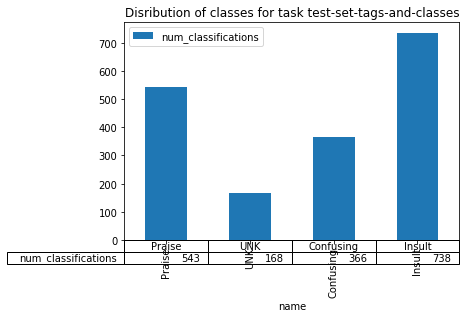

In [183]:
data = session.get(test_td+'classification_count/').json()
pd.DataFrame(data).set_index('name').plot.bar(table=True,
    title="Disribution of classes for task {name}".format(name="test-set-tags-and-classes"))

### Analyzing the agreement of classes
When labeling with more than one annotator per example, we should also look at the agreement level. LightTags *classification_agg* endpoint, which sits under a particular task definition, will give you those results. That is, you will see, per class, how many of its instances were agreed upon by 1,2..n labelers who saw that example

In [184]:
data = session.get(test_td+'classification_agg/').json() # Get the data
class_agg = pd.DataFrame(data)

It is often instructive to pivot and plot this metric

In [185]:
class_agg_p = class_agg.pivot_table(index='name',columns='agrees',values='count')
class_agg_p

agrees,1,2,3
name,,,
Confusing,246,48,8
Insult,274,181,34
Praise,282,105,17
UNK,144,9,2


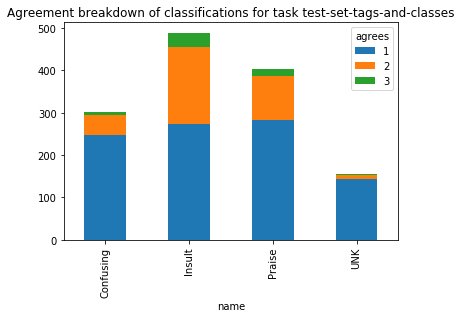

In [186]:
class_agg_p.plot.bar(
    stacked=True,
    title="Agreement breakdown of classifications for task {name}".format(name="test-set-tags-and-classes")
)

And transposing the pivot table can also be indicative, in this example it makes clear that only the Insult class gets significnt "full agreement"

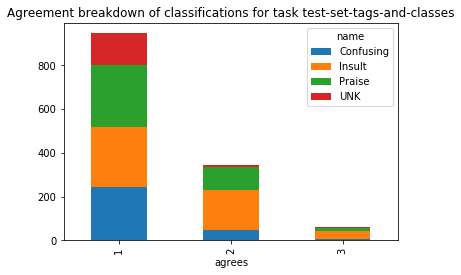

In [187]:
class_agg_p.T.plot.bar(
    stacked=True,
    title="Agreement breakdown of classifications for task {name}".format(name="test-set-tags-and-classes")
)

### Classsiffication Confusion Matrix
As we see above, often times our labelers do not agree. In the example above (on synthetic data) we see that most of the time our labelers do not agree at all, regardless of the class. In these instances, it is often convenient to construct a confusion matrix and see which classes our labelers confusing the most. In turn, this lets us update our instructions or Schema to ensure quality data
LightTag provides a confusion matrix for classifications under the **classification_confusion** endpoint of a taskdefinition

In [188]:
data = session.get(test_td+'classification_confusion/').json() #Fetch the confusion matrix
class_confusion = pd.DataFrame(data)
class_confusion

,class_a,class_b,count
0,Confusing,Confusing,72
1,Confusing,Insult,175
2,Confusing,Praise,105
3,Confusing,UNK,31
4,Insult,Confusing,130
5,Insult,Insult,283
6,Insult,Praise,208
7,Insult,UNK,76
8,Praise,Confusing,117
9,Praise,Insult,248


Again, it is often convenient to pivot the data

In [189]:
class_confusion_p= (class_confusion.pivot_table(index='class_a',columns='class_b',values='count'))
class_confusion_p


class_b,Confusing,Insult,Praise,UNK
class_a,,,,
Confusing,72,175,105,31
Insult,130,283,208,76
Praise,117,248,156,49
UNK,30,73,47,15


And visualize it as a heatmap


In [190]:
class_confusion_p.div(class_confusion_p.sum(1),axis=0).cumsum(1)

class_b,Confusing,Insult,Praise,UNK
class_a,,,,
Confusing,0.187990,0.644909,0.919060,1.0
Insult,0.186514,0.592539,0.890961,1.0
Praise,0.205263,0.640351,0.914035,1.0
UNK,0.181818,0.624242,0.909091,1.0


## Tag Metrics
The metrics we are interested in with tags are similar to classifications with some subtle differences. In LightTag, a single example has only one classification but can have many tags. Additionaly, a tag has a location as well as a type. For example in "President Donald Trump" Donald Trump has type "Person", starts at 11 and ends at 23.
Thus when we calculate agreement things get a little more subtle

### Fetching counts and agreements for tags
Exactly as we did for classsifications, we can fetch the distribution of each tag from a taskdefinitions **tag_count** endpoint

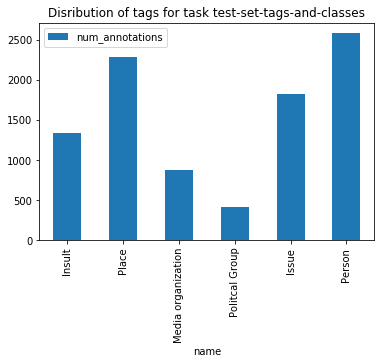

In [191]:
data = session.get(test_td+'tag_count/').json()
pd.DataFrame(data).set_index('name').plot.bar(
    title="Disribution of tags for task {name}".format(name="test-set-tags-and-classes"))

Similarly we can fetch the agreements from the **tag_agg** endpoint

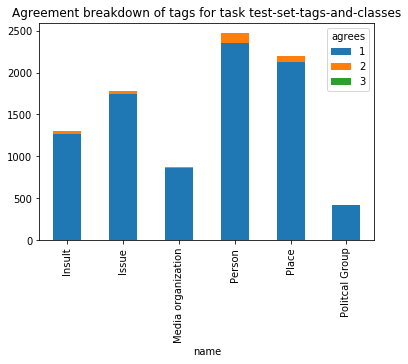

In [192]:
data = session.get(test_td+'tag_agg/').json()
pd.DataFrame(data).pivot_table(index='name',columns='agrees',values='count').plot.bar(
    stacked=True,
    
    title="Agreement breakdown of tags for task {name}".format(name="test-set-tags-and-classes")
)

## Tag level error analysis and confusion matrix
Similar to classifications, we'd like to understand why are labelers are disagreeing. As mentioned before, tags have a location in the example which means their are a number of possible ways to disagree. The endpoint **tag_confusion** on a task definition will return the error type; it's possible values are
### Types of tag errors
1. **agree** The location and type of the annotation were equal (this is ideal)
2. **singular** Annotator A annotated but annotator B did not
3. **tag_mismatch** Annotator A and B agreed on the location of an annotation but not it's tag. For example, "White House" might have been labeled by A as location and B as Organization
4. **span_mismatch** Annotator A and B made an overlapping annotation with the same type, but the they were not equal. For example, "President Donald Trump", A and B will both label "Person" but A selected "President Donald Trump" and B ommited President, labeling only "Donald Trump"
5. **tag_span_mismatch** A and B made an overlapping annotation, but the location was not equal and the tag was different. For example, "The White House", A labeled the entire phrase as Location while B labeled just "White House" as an organisation

In [193]:
import seaborn as sns
data = session.get(test_td+'tag_confusion/').json() # Fetch the tag level 
D = pd.DataFrame(data).fillna('')  #Fill null entriess with a blank string
D.head(10)


,count,error,tag_a,tag_b
0,31,agree,Insult,Insult
1,46,agree,Issue,Issue
2,11,agree,Media organization,Media organization
3,118,agree,Person,Person
4,84,agree,Place,Place
5,3,agree,Politcal Group,Politcal Group
6,880,singular,Insult,
7,1228,singular,Issue,
8,615,singular,Media organization,
9,1707,singular,Person,


As always, it is convenient to pivot the data, this time using a multi index

In [194]:
Res =D.pivot_table(index=['tag_a','tag_b'],columns=['error'],values='count',)
Res = Res.fillna(0)
Res

error                                  agree  singular  span_mismatch  \
tag_a              tag_b                                                
Insult                                   0.0     880.0            0.0   
                   Insult               31.0       0.0           49.0   
                   Issue                 0.0       0.0            0.0   
                   Media organization    0.0       0.0            0.0   
                   Person                0.0       0.0            0.0   
                   Place                 0.0       0.0            0.0   
                   Politcal Group        0.0       0.0            0.0   
Issue                                    0.0    1228.0            0.0   
                   Insult                0.0       0.0            0.0   
                   Issue                46.0       0.0           98.0   
                   Media organization    0.0       0.0            0.0   
                   Person                0.0       0.0            0.0   
                   Place                 0.0       0.0            0.0   
                   Politcal Group        0.0       0.0            0.0   
Media organization                       0.0     615.0            0.0   
                   Insult                0.0       0.0            0.0   
                   Issue                 0.0       0.0            0.0   
                   Media organization   11.0       0.0           31.0   
                   Person                0.0       0.0            0.0   
                   Place                 0.0       0.0            0.0   
                   Politcal Group        0.0       0.0            0.0   
Person                                   0.0    1707.0            0.0   
                   Insult                0.0       0.0            0.0   
                   Issue                 0.0       0.0            0.0   
                   Media organization    0.0       0.0            0.0   
                   Person              118.0       0.0          198.0   
                   Place                 0.0       0.0            0.0   
                   Politcal Group        0.0       0.0            0.0   
Place                                    0.0    1509.0            0.0   
                   Insult                0.0       0.0            0.0   
                   Issue                 0.0       0.0            0.0   
                   Media organization    0.0       0.0            0.0   
                   Person                0.0       0.0            0.0   
                   Place                84.0       0.0          150.0   
                   Politcal Group        0.0       0.0            0.0   
Politcal Group                           0.0     253.0            0.0   
                   Insult                0.0       0.0            0.0   
                   Issue                 0.0       0.0            0.0   
                   Media organization    0.0       0.0            0.0   
                   Person                0.0       0.0            0.0   
                   Place                 0.0       0.0            0.0   
                   Politcal Group        3.0       0.0            4.0   

error                                  span_tag_mismatch  tag_mismatch  
tag_a              tag_b                                                
Insult                                               0.0           0.0  
                   Insult                            0.0           0.0  
                   Issue                            64.0          41.0  
                   Media organization               31.0          14.0  
                   Person                          112.0          47.0  
                   Place                            88.0          44.0  
                   Politcal Group                   22.0          13.0  
Issue                                                0.0           0.0  
                   Insult                           53.0 

## Downloading Results
Of course, sometimes we just want to results
These are easily attained from a task_definitions **download** endpoint
The download view returns "everything", that is it returns the entire schema definition, dataset definition, all of the examples and the annotations and classifications. We'll quickly explore the structure of the results here

In [198]:
test_td

'http://localhost:8000/api/v1/projects/default/task_definitions/test-set-tags-and-classes/'

In [200]:
data = session.get(test_td+'download/').json() 


In [201]:
res= data['result']
x = next(filter(lambda x:x['results']['annotations'],res))

In [202]:
x

{'example': {'content': "Great listening session with CEO's of the Retail Industry Leaders Association this morning! https://t.co/sy6xJcWfcF",
  'definition_id': 'f91a95a4-61e5-40f8-87b4-63103e1f00f0',
  'example_id': '008eb3c3-ac50-474e-b58c-04f755987ca0',
  'metadata': {'created_at': 'Wed Feb 15 16:34:27 +0000 2017',
   'date': '2017-02-15',
   'favorite_count': 66081,
   'id_str': '831904516316479489',
   'in_reply_to_user_id_str': None,
   'is_retweet': False,
   'retweet_count': 10692,
   'source': 'Twitter for iPhone',
   'time': 1487176467000000000}},
 'results': {'annotations': [{'annotator_id': 2,
    'end': 65,
    'from_suggestion': False,
    'start': 58,
    'tag': 'Issue',
    'value': 'Leaders'},
   {'annotator_id': 4,
    'end': 5,
    'from_suggestion': False,
    'start': 0,
    'tag': 'Issue',
    'value': 'Great'},
   {'annotator_id': 4,
    'end': 48,
    'from_suggestion': False,
    'start': 38,
    'tag': 'Person',
    'value': 'the Retail'},
   {'annotator_id':

In [203]:
data.keys()

dict_keys(['schema', 'dataset', 'id', 'result'])

The dataset and schema fields are the same we've seen before when we defined our schema and dataset. LightTag provides them so you don't need to do further lookups.

The actual results live in the result key, which itself contains a list.
Each item in that list contains the **example** that was annotated and the results of the annotation 

In [204]:
data['result'][0].keys()


dict_keys(['results', 'example'])

The results field further divides into annotations and classifications

In [205]:
data['result'][0]['results'].keys()

dict_keys(['annotations', 'classifications'])

An annotation result contains the 
1. id of the annotator, 
2. the start and end of the annotation, 
3. the tag applied, 
4. the value, that is the string that was captured

In [206]:
data['result'][0]['results']['annotations'][0]

{'annotator_id': 2,
 'end': 65,
 'from_suggestion': False,
 'start': 58,
 'tag': 'Issue',
 'value': 'Leaders'}

A classification result contains the 
1. id of the annotator, 
3. the classname applied, 


In [207]:
data['result'][0]['results']['classifications'][0]

{'annotator_id': 4, 'classname': 'Praise'}

The example field contains the text we labeled

In [208]:
data['result'][0]['example']['content']

"Great listening session with CEO's of the Retail Industry Leaders Association this morning! https://t.co/sy6xJcWfcF"

As well as any additional metadata we provided

In [209]:
data['result'][0]['example']['metadata']

{'created_at': 'Wed Feb 15 16:34:27 +0000 2017',
 'date': '2017-02-15',
 'favorite_count': 66081,
 'id_str': '831904516316479489',
 'in_reply_to_user_id_str': None,
 'is_retweet': False,
 'retweet_count': 10692,
 'source': 'Twitter for iPhone',
 'time': 1487176467000000000}

### Running custom analytics
Sometimes we want to do some analysis on our data that LightTag does not yet provide. In that case we are down to simple JSON manipilation. 
Let's get the top 5 words for each tag as an example

In [210]:
#Aggregate all of the results
annotations = []
for result in data['result']:
    annotations +=result['results']['annotations']

In [211]:
annotations_df = pd.DataFrame(annotations)
z = annotations_df.groupby('tag').value.value_counts()
z.groupby(level=0).nlargest(5).unstack().T

tag,Insult,Issue,Media organization,Person,Place,Politcal Group
tag,Insult,Issue,Media organization,Person,Place,Politcal Group
value,,,,,,
I,NaN,NaN,NaN,NaN,NaN,7.0
and,NaN,27.0,13.0,41.0,38.0,7.0
co,NaN,27.0,NaN,NaN,36.0,NaN
for,NaN,NaN,11.0,NaN,NaN,NaN
https,20.0,NaN,NaN,NaN,NaN,NaN
is,20.0,NaN,NaN,NaN,NaN,NaN
of,16.0,NaN,14.0,34.0,NaN,NaN
t,NaN,26.0,NaN,46.0,41.0,7.0
